In [1]:
from db_queries import get_population, get_ids
from db_queries import get_location_metadata as get_locs

In [2]:
import pandas as pd, numpy as np

go through, choose numbers for each datapoint for which we have dat
    - reextract as necessary
 

check against what we need, fill in guesses for what we don't have

In [3]:
output = pd.DataFrame()

In [4]:
location_names = ['India','Ethiopia','Nigeria']

In [5]:
gday_path =  '/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/inputs/gday_extraction_sheet_02_22_2021.csv'
gday = pd.read_csv(gday_path)

In [6]:
gday.head()

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,value_975_percentile,sub_population,source_citation,source_link,source_year,source_type,notes,user,date_recorded
0,160.0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,168.0,Angola,NaN,NaN,mixed/both,wheat flour,na,Median amount of vehicle consumed on previous ...,49,NaN,NaN,total population,NaN,https://www.nutritionintl.org/content/user_fil...,1997-2000,Survey - cross-sectional,Estimates of wheat flour and maize meal consum...,rohit,12/2/2020
2,168.0,Angola,NaN,NaN,mixed/both,maize flour,na,Median amount of vehicle consumed on previous ...,72,NaN,NaN,total population,NaN,https://www.nutritionintl.org/content/user_fil...,1997-2000,Survey - cross-sectional,Estimates of wheat flour and maize meal consum...,rohit,12/2/2020
3,168.0,Angola,NaN,NaN,mixed/both,wheat flour,na,Median amount of vehicle consumed on previous ...,89.32,NaN,NaN,total population,GFDx,https://fortificationdata.org/country-fortific...,2019,NaN,(grams/capita/day)Daily food availability,paulina,12/11/2020
4,168.0,Angola,NaN,NaN,mixed/both,maize flour,na,Median amount of vehicle consumed on previous ...,154.99,NaN,NaN,total population,GFDx,https://fortificationdata.org/country-fortific...,2019,NaN,(grams/capita/day)Daily food availability,paulina,12/11/2020


In [7]:
gday[gday.location_id.isna()].location_name.unique()

array(['China ', 'Egypt', 'Nepal', 'South Africa'], dtype=object)

In [8]:
gday[gday.location_name.isna()]

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,value_975_percentile,sub_population,source_citation,source_link,source_year,source_type,notes,user,date_recorded


In [9]:
gday.location_id = gday.location_id.fillna(-1).astype(int)

In [10]:
gday.location_name.unique()

array(['Afghanistan', 'Angola', 'Bangladesh', 'Burkina Faso',
       "Côte d'Ivoire", 'Cameroon', 'Chad', 'China ',
       'Democratic Republic of the Congo', 'Egypt', 'Ethiopia', 'Ghana',
       'India', 'Indonesia', 'Kenya', 'Madagascar', 'Mozambique',
       'Myanmar', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Philippines',
       'South Africa', 'Sudan', 'Uganda', 'United Republic of Tanzania',
       'Viet Nam', 'Yemen', 'Zambia'], dtype=object)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<function matplotlib.pyplot.show(close=None, block=None)>

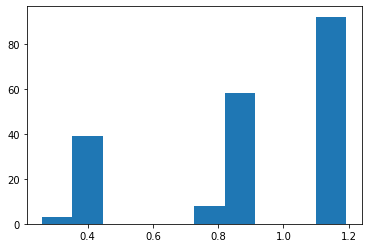

In [11]:
## estimate CIs

from scipy.stats import variation

gday.loc[gday.value_mean=='na','value_mean'] = np.nan
gday.value_mean = gday.value_mean.astype(float)

cv = variation(gday[(gday.vehicle=="maize flour")].value_mean)

pd.DataFrame([1,2,3,4,5,100]).apply(lambda x : np.mean(x))

cvs = gday[(gday.value_mean!='na') & (gday.value_mean.notna())].groupby('vehicle').value_mean.apply(variation)

cvs.name = 'coeff_var'

gday = gday.merge(cvs, on = 'vehicle')

gday['dev'] = gday.value_mean * gday.coeff_var

gday[['value_mean','dev']]

gday['lower'] = (gday.value_mean - (1.282)*gday.dev).clip(lower = 0) #90th percentile
gday['upper'] = (gday.value_mean + (1.282)*gday.dev)

import matplotlib.pyplot as plt

plt.hist((gday.upper - gday.value_mean)/gday.value_mean)
plt.show

In [12]:
value_d_to_metric = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'median',
 'Mean per capita consumption (g/day)': 'mean',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'mean',
 'Mean micronutrient intake per capita (mg/day)': 'mean',
 'Daily per capita consumption (g)': 'CHECK',
 'Daily consumption (mg/d)': 'CHECK',
 'Consumption per person per day (g)': 'CHECK',
 'Estimated daily contribution from fortified foods (mg/d)': 'CHECK',
 'kg/capita/year': 'CHECK'
}

In [13]:
value_d_to_entity = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'vehicle',
 'Mean per capita consumption (g/day)': 'CHECK',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'vehicle',
 'Mean micronutrient intake per capita (mg/day)': 'nutrient',
 'Daily per capita consumption (g)': 'CHECK',
 'Daily consumption (mg/d)': 'CHECK',
 'Consumption per person per day (g)': 'CHECK',
 'Estimated daily contribution from fortified foods (mg/d)': 'CHECK',
 'kg/capita/year': 'CHECK'
}

In [14]:
value_d_to_mass_unit = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'g',
 'Mean per capita consumption (g/day)': 'g',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'g',
 'Mean micronutrient intake per capita (mg/day)': 'mg',
 'Daily per capita consumption (g)': 'g',
 'Daily consumption (mg/d)': 'mg',
 'Consumption per person per day (g)': 'g',
 'Estimated daily contribution from fortified foods (mg/d)': 'mg',
 'kg/capita/year': 'kg'
}

In [15]:
value_d_to_time_unit = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'day',
 'Mean per capita consumption (g/day)': 'day',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'day',
 'Mean micronutrient intake per capita (mg/day)': 'day',
 'Daily per capita consumption (g)': 'day',
 'Daily consumption (mg/d)': 'day',
 'Consumption per person per day (g)': 'day',
 'Estimated daily contribution from fortified foods (mg/d)': 'day',
 'kg/capita/year': 'year'
}

In [16]:
value_d_to_population = {
 'Median amount of vehicle consumed on previous day among consumers (g/day)': 'consumers',
 'Mean per capita consumption (g/day)': 'capita CHECK',
 'Mean amount of vehicle consumed on previous day among consumers (g/day)': 'consumers',
 'Mean micronutrient intake per capita (mg/day)': 'capita CHECK',
 'Daily per capita consumption (g)': 'capita CHECK',
 'Daily consumption (mg/d)': 'CHECK',
 'Consumption per person per day (g)': 'CHECK',
 'Estimated daily contribution from fortified foods (mg/d)': 'CHECK',
 'kg/capita/year': 'CHECK'
}

In [17]:
def format_value_d(df):
    df['metric'] = df.value_description.map(value_d_to_metric)
    df['entity'] = df.value_description.map(value_d_to_entity)
    df['mass_unit'] = df.value_description.map(value_d_to_mass_unit)
    df['time_unit'] = df.value_description.map(value_d_to_time_unit)
    df['pop_denom'] = df.value_description.map(value_d_to_population)
    
    return df

In [18]:
nigeria = gday[gday.location_name=="Nigeria"]

nigeria = format_value_d(nigeria)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [19]:
loc_metadata = get_locs(location_set_id=35, gbd_round_id=6, decomp_step="step4")

In [20]:
nigeria_subnat_ids = {
    'Ebonyi':25328,
    'Sokoto':25351
}

In [21]:
pop = get_population(age_group_id=22, 
                     location_id=list(nigeria_subnat_ids.values()),
                     year_id=2018,
                     sex_id=3,
                     gbd_round_id=6, 
                     decomp_step='step5')

In [22]:
nigeria['subnational_id'] = nigeria.subnational_name.map(nigeria_subnat_ids)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
nigeria = nigeria.merge(pop[['location_id','population']].rename(columns={'location_id':'subnational_id'}), on = 'subnational_id', how = 'left')

In [24]:
nigeria.sort_values('vehicle')

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,dev,lower,upper,metric,entity,mass_unit,time_unit,pop_denom,subnational_id,population
6,214,Nigeria,Ebonyi,NaN,unknown,bouillon,na,Mean amount of vehicle consumed on previous da...,2.00,na,...,0.596133,1.235757,2.764243,mean,vehicle,g,day,consumers,25328.0,3.163671e+06
7,214,Nigeria,Sokoto,NaN,unknown,bouillon,na,Mean amount of vehicle consumed on previous da...,3.00,na,...,0.894200,1.853635,4.146365,mean,vehicle,g,day,consumers,25351.0,6.384879e+06
2,214,Nigeria,na,NaN,unknown,maize flour,na,Mean amount of vehicle consumed on previous da...,54.00,na,...,35.567618,8.402314,99.597686,mean,vehicle,g,day,consumers,NaN,NaN
3,214,Nigeria,na,NaN,unknown,maize flour,na,Mean per capita consumption (g/day),95.10,na,...,62.638527,14.797408,175.402592,mean,CHECK,g,day,capita CHECK,NaN,NaN
4,214,Nigeria,NaN,NaN,NaN,maize flour,na,Mean per capita consumption (g/day),69.70,NaN,...,45.908573,10.845209,128.554791,mean,CHECK,g,day,capita CHECK,NaN,NaN
9,214,Nigeria,na,NaN,unknown,rice,na,Mean per capita consumption (g/day),126.90,na,...,73.621781,32.516876,221.283124,mean,CHECK,g,day,capita CHECK,NaN,NaN
10,214,Nigeria,Ebonyi,NaN,unknown,rice,na,Mean amount of vehicle consumed on previous da...,80.00,na,...,46.412471,20.499213,139.500787,mean,vehicle,g,day,consumers,25328.0,3.163671e+06
11,214,Nigeria,Sokoto,NaN,unknown,rice,na,Mean amount of vehicle consumed on previous da...,97.00,na,...,56.275121,24.855295,169.144705,mean,vehicle,g,day,consumers,25351.0,6.384879e+06
12,214,Nigeria,na,NaN,unknown,rice,na,Consumption per person per day (g),77.00,na,...,44.672003,19.730492,134.269508,CHECK,CHECK,g,day,CHECK,NaN,NaN
8,214,Nigeria,na,NaN,unknown,salt,na,Mean amount of vehicle consumed on previous da...,7.20,na,...,1.464328,5.322732,9.077268,mean,vehicle,g,day,consumers,NaN,NaN


In [25]:
## we can population-weight bouillon

In [26]:
nigeria[nigeria.vehicle=="bouillon"][['metric', 'vehicle', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
6,mean,bouillon,vehicle,g,day,consumers,2018,2.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Ebonyi
7,mean,bouillon,vehicle,g,day,consumers,2018,3.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Sokoto


In [27]:
output = output.append(nigeria[nigeria.vehicle=="bouillon"])

In [28]:
view_cols = ['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']

In [29]:
nigeria.loc[nigeria.vehicle=="maize flour",view_cols] 

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
2,maize flour,mean,vehicle,g,day,consumers,1997-2000,54.0,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
3,maize flour,mean,CHECK,g,day,capita CHECK,2017,95.1,GFDx,https://fortificationdata.org/country-fortific...,total population,na
4,maize flour,mean,CHECK,g,day,capita CHECK,2007,69.7,"Nuss, E. T., & Tanumihardjo, S. A. (2011). Qua...",https://doi.org/10.3945/an.110.000182,total population,NaN


In [30]:
# use most recent maize flour data (these all come from FAO, some via different methods)

In [31]:
nigeria.loc[(nigeria.vehicle=="maize flour") & (nigeria.source_year=="2017")]

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,dev,lower,upper,metric,entity,mass_unit,time_unit,pop_denom,subnational_id,population
3,214,Nigeria,na,NaN,unknown,maize flour,na,Mean per capita consumption (g/day),95.1,na,...,62.638527,14.797408,175.402592,mean,CHECK,g,day,capita CHECK,NaN,NaN


In [32]:
output = output.append(nigeria.loc[(nigeria.vehicle=="maize flour") & (nigeria.source_year=="2017")])

In [33]:
nigeria.loc[nigeria.vehicle=="rice",['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
9,mean,CHECK,g,day,capita CHECK,2017,126.9,GFDx,https://fortificationdata.org/country-fortific...,total population,na
10,mean,vehicle,g,day,consumers,2018,80.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Ebonyi
11,mean,vehicle,g,day,consumers,2018,97.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Sokoto
12,CHECK,CHECK,g,day,CHECK,2013,77.0,NaN,https://issuu.com/sight_and_life/docs/sightand...,total population,na


In [34]:
# for rice, use the WRA numbers (recent enough)

In [35]:
nigeria.loc[(nigeria.vehicle=="rice") & (nigeria.sub_population=="women of reproductive age"),['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
10,mean,vehicle,g,day,consumers,2018,80.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Ebonyi
11,mean,vehicle,g,day,consumers,2018,97.0,NaN,https://www.gainhealth.org/sites/default/files...,women of reproductive age,Sokoto


In [36]:
output = output.append(nigeria.loc[(nigeria.vehicle=="rice") & (nigeria.sub_population=="women of reproductive age"),])

In [37]:
# we only have one salt number

In [38]:
nigeria.loc[nigeria.vehicle=="salt",['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
8,mean,vehicle,g,day,consumers,2017,7.2,GFDx,https://fortificationdata.org/country-fortific...,total population,na


In [39]:
output = output.append(nigeria.loc[nigeria.vehicle=="salt",])

In [40]:
nigeria.loc[["wheat" in i for i in nigeria.vehicle],['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
0,wheat flour,mean,vehicle,g,day,consumers,1997-2000,26.00,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
1,wheat flour,mean,CHECK,g,day,capita CHECK,2017,49.15,GFDx,https://fortificationdata.org/country-fortific...,total population,na
5,wheat(not specifically flour),mean,CHECK,g,day,capita CHECK,2000-2009,54.49,"Mason, N. M., Jayne, T. S., & Shiferaw, B. A. ...",https://ageconsearch.umn.edu/record/146936/fil...,total population,na


In [41]:
## for wheat flour, take most recent year

In [42]:
nigeria.loc[(["wheat" in i for i in nigeria.vehicle]) & (nigeria.source_year=="2017") ,['vehicle','metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']] 

,vehicle,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
1,wheat flour,mean,CHECK,g,day,capita CHECK,2017,49.15,GFDx,https://fortificationdata.org/country-fortific...,total population,na


In [43]:
output = output.append(nigeria.loc[(["wheat" in i for i in nigeria.vehicle]) & (nigeria.source_year=="2017") ,])

## ethiopia

In [44]:
ethiopia = gday[gday.location_name=="Ethiopia"]
ethiopia = format_value_d(ethiopia)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [45]:
ethiopia.sort_values('vehicle')

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,date_recorded,coeff_var,dev,lower,upper,metric,entity,mass_unit,time_unit,pop_denom
108,179,Ethiopia,na,NaN,unknown,maize flour,na,Mean per capita consumption (g/day),113.84,na,...,12/11/2020,0.658660,74.981808,17.713322,209.966678,mean,CHECK,g,day,capita CHECK
109,179,Ethiopia,NaN,NaN,NaN,maize flour,na,Mean per capita consumption (g/day),113.60,NaN,...,12/17/2020,0.658660,74.823729,17.675979,209.524021,mean,CHECK,g,day,capita CHECK
190,179,Ethiopia,na,NaN,unknown,salt,na,Mean per capita consumption (g/day),5.80,na,...,12/11/2020,0.203379,1.179597,4.287756,7.312244,mean,CHECK,g,day,capita CHECK
45,179,Ethiopia,na,NaN,unknown,wheat flour,na,Mean amount of vehicle consumed on previous da...,54.00,na,...,12/11/2020,0.930306,50.236551,0.000000,118.403258,mean,vehicle,g,day,consumers
46,179,Ethiopia,na,NaN,unknown,wheat flour,na,Mean per capita consumption (g/day),97.64,na,...,12/11/2020,0.930306,90.835126,0.000000,214.090631,mean,CHECK,g,day,capita CHECK
139,179,Ethiopia,na,NaN,NaN,wheat(not specifically flour),na,Mean per capita consumption (g/day),92.74,NaN,...,12/17/2020,0.666694,61.829167,13.475008,172.004992,mean,CHECK,g,day,capita CHECK


In [46]:
ethiopia.sort_values('vehicle')[['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
108,mean,CHECK,g,day,capita CHECK,2017,113.84,NaN,https://fortificationdata.org/country-fortific...,total population,na
109,mean,CHECK,g,day,capita CHECK,2007,113.60,"Nuss, E. T., & Tanumihardjo, S. A. (2011). Qua...",https://doi.org/10.3945/an.110.000182,total population,NaN
190,mean,CHECK,g,day,capita CHECK,2017,5.80,NaN,https://fortificationdata.org/country-fortific...,total population,na
45,mean,vehicle,g,day,consumers,1997-2000,54.00,NaN,https://www.nutritionintl.org/content/user_fil...,total population,na
46,mean,CHECK,g,day,capita CHECK,2017,97.64,NaN,https://fortificationdata.org/country-fortific...,total population,na
139,mean,CHECK,g,day,capita CHECK,2000-2009,92.74,"Mason, N. M., Jayne, T. S., & Shiferaw, B. A. ...",https://ageconsearch.umn.edu/record/146936/fil...,total population,na


In [47]:
ethiopia[ethiopia.vehicle=="maize flour"][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
108,mean,CHECK,g,day,capita CHECK,2017,113.84,NaN,https://fortificationdata.org/country-fortific...,total population,na
109,mean,CHECK,g,day,capita CHECK,2007,113.60,"Nuss, E. T., & Tanumihardjo, S. A. (2011). Qua...",https://doi.org/10.3945/an.110.000182,total population,NaN


In [48]:
## take the more recent one
ethiopia[(ethiopia.vehicle=="maize flour") & (ethiopia.source_year=="2017")][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
108,mean,CHECK,g,day,capita CHECK,2017,113.84,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [49]:
output = output.append(ethiopia[(ethiopia.vehicle=="maize flour") & (ethiopia.source_year=="2017")])

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v105/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [50]:
# only one salt number
ethiopia[ethiopia.vehicle=="salt"][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
190,mean,CHECK,g,day,capita CHECK,2017,5.8,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [51]:
output = output.append(ethiopia[ethiopia.vehicle=="salt"])

In [52]:
## take most recent
ethiopia[(["wheat" in i for i in ethiopia.vehicle]) & (ethiopia.source_year=="2017")][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
46,mean,CHECK,g,day,capita CHECK,2017,97.64,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [53]:
output = output.append(ethiopia[(["wheat" in i for i in ethiopia.vehicle]) & (ethiopia.source_year=="2017")])

## india

In [54]:
india = gday[gday.location_name=="India"]
india = format_value_d(india)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [55]:
india.sort_values('vehicle')

,location_id,location_name,subnational_name,subnational_location_id,urbanicity,vehicle,nutrient,value_description,value_mean,value_025_percentile,...,date_recorded,coeff_var,dev,lower,upper,metric,entity,mass_unit,time_unit,pop_denom
195,163,India,na,NaN,mixed/both,rice,na,Mean per capita consumption (g/day),282.77,NaN,...,12/10/2020,0.580156,164.050679,72.457030,493.082970,mean,CHECK,g,day,capita CHECK
196,163,India,na,NaN,mixed/both,rice,na,Mean per capita consumption (g/day),291.00,NaN,...,12/15/2020,0.580156,168.825362,74.565886,507.434114,mean,CHECK,g,day,capita CHECK
191,163,India,na,NaN,mixed/both,salt,na,Mean amount of vehicle consumed on previous da...,9.50,NaN,...,12/10/2020,0.203379,1.932099,7.023049,11.976951,mean,vehicle,g,day,consumers
50,163,India,na,NaN,mixed/both,wheat flour,na,Mean per capita consumption (g/day),169.62,NaN,...,12/10/2020,0.930306,157.798587,0.000000,371.917789,mean,CHECK,g,day,capita CHECK
51,163,India,na,NaN,mixed/both,wheat flour,na,Mean per capita consumption (g/day),164.00,NaN,...,12/15/2020,0.930306,152.570265,0.000000,359.595079,mean,CHECK,g,day,capita CHECK


In [56]:
india.sort_values('vehicle')[['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
195,mean,rice,CHECK,g,day,capita CHECK,2018,282.77,NaN,https://fortificationdata.org/country-fortific...,total population,na
196,mean,rice,CHECK,g,day,capita CHECK,2007,291.00,NaN,https://www.hunger-undernutrition.org/blog/201...,total population,na
191,mean,salt,vehicle,g,day,consumers,2018,9.50,NaN,https://fortificationdata.org/country-fortific...,total population,na
50,mean,wheat flour,CHECK,g,day,capita CHECK,2018,169.62,NaN,https://fortificationdata.org/country-fortific...,total population,na
51,mean,wheat flour,CHECK,g,day,capita CHECK,2007,164.00,NaN,https://www.hunger-undernutrition.org/blog/201...,total population,na


In [57]:
#take more recent datapoint

india[(india.vehicle=="rice") & (india.source_year=="2018")][['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
195,mean,rice,CHECK,g,day,capita CHECK,2018,282.77,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [58]:
output = output.append(india[(india.vehicle=="rice") & (india.source_year=="2018")])

In [59]:
#only one datapoint
india[(india.vehicle=="salt")][['metric', 'vehicle' ,'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,vehicle,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
191,mean,salt,vehicle,g,day,consumers,2018,9.5,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [60]:
output = output.append(india[(india.vehicle=="salt")])

In [61]:
## take most recent
india[(["wheat" in i for i in india.vehicle]) & (india.source_year=="2018")][['metric', 'entity', 'mass_unit', 'time_unit',
       'pop_denom','source_year','value_mean','source_citation','source_link','sub_population','subnational_name']]

,metric,entity,mass_unit,time_unit,pop_denom,source_year,value_mean,source_citation,source_link,sub_population,subnational_name
50,mean,CHECK,g,day,capita CHECK,2018,169.62,NaN,https://fortificationdata.org/country-fortific...,total population,na


In [62]:
output = output.append(india[(["wheat" in i for i in india.vehicle]) & (india.source_year=="2018")])

## format output

In [63]:
output.pop_denom = output.pop_denom.map({'consumers': 'consumers', 'capita CHECK': 'capita'})

In [64]:
output.value_mean = output.value_mean.astype(float)

In [65]:
output.value_025_percentile = output.value_025_percentile.map({'na':np.nan}).astype(float)
output.value_975_percentile = output.value_975_percentile.map({'na':np.nan}).astype(float)

In [66]:
vet_cols = ['entity', 'location_name', 'mass_unit',
       'metric', 'notes', 'nutrient', 'pop_denom', 'population', 'source_link',
       'sub_population', 'subnational_id',
       'subnational_name', 'time_unit', 'urbanicity', 'user', 'value_description',
       'value_mean','vehicle']

output[vet_cols]

,entity,location_name,mass_unit,metric,notes,nutrient,pop_denom,population,source_link,sub_population,subnational_id,subnational_name,time_unit,urbanicity,user,value_description,value_mean,vehicle
6,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,3.163671e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25328.0,Ebonyi,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,2.00,bouillon
7,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,6.384879e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25351.0,Sokoto,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,3.00,bouillon
3,CHECK,Nigeria,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),95.10,maize flour
10,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,3.163671e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25328.0,Ebonyi,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,80.00,rice
11,vehicle,Nigeria,g,mean,"in terms of consumption patterns, women of rep...",na,consumers,6.384879e+06,https://www.gainhealth.org/sites/default/files...,women of reproductive age,25351.0,Sokoto,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,97.00,rice
8,vehicle,Nigeria,g,mean,(grams/capita/day)Daily food availability,na,consumers,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean amount of vehicle consumed on previous da...,7.20,salt
1,CHECK,Nigeria,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),49.15,wheat flour
108,CHECK,Ethiopia,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),113.84,maize flour
190,CHECK,Ethiopia,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),5.80,salt
46,CHECK,Ethiopia,g,mean,(grams/capita/day)Daily food availability,na,capita,NaN,https://fortificationdata.org/country-fortific...,total population,NaN,na,day,unknown,paulina,Mean per capita consumption (g/day),97.64,wheat flour


In [67]:
#for now we'll drop percentiles, then add back in
output[['location_name','vehicle','value_mean','value_025_percentile','value_025_percentile','lower','upper']]

,location_name,vehicle,value_mean,value_025_percentile,value_025_percentile,lower,upper
6,Nigeria,bouillon,2.00,NaN,NaN,1.235757,2.764243
7,Nigeria,bouillon,3.00,NaN,NaN,1.853635,4.146365
3,Nigeria,maize flour,95.10,NaN,NaN,14.797408,175.402592
10,Nigeria,rice,80.00,NaN,NaN,20.499213,139.500787
11,Nigeria,rice,97.00,NaN,NaN,24.855295,169.144705
8,Nigeria,salt,7.20,NaN,NaN,5.322732,9.077268
1,Nigeria,wheat flour,49.15,NaN,NaN,0.000000,107.768891
108,Ethiopia,maize flour,113.84,NaN,NaN,17.713322,209.966678
190,Ethiopia,salt,5.80,NaN,NaN,4.287756,7.312244
46,Ethiopia,wheat flour,97.64,NaN,NaN,0.000000,214.090631


In [68]:
group_cols = ['location_id','location_name','sub_population','vehicle','metric','mass_unit','time_unit','pop_denom'] #,'subnational_name']

In [77]:
# weight by subnational population
output['subnat_pop_denom'] = output.groupby(group_cols).transform(sum).population

output['subnat_pop_weight'] = [(i/j) if j!=0.0 else 1 for (i,j) in zip(output.population,output.subnat_pop_denom)]

output.value_mean = output.value_mean * output.subnat_pop_weight

output = output[group_cols + ['value_mean','lower','upper']].groupby(group_cols).sum()

value_mean  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     282.770000   
                                                    salt        mean   g         day       consumers    9.500000   
                                                    wheat flour mean   g         day       capita     169.620000   
179         Ethiopia      total population          maize flour mean   g         day       capita     113.840000   
                                                    salt        mean   g         day       capita       5.800000   
                                                    wheat flour mean   g         day       capita      97.640000   
214         Nigeria       total population          maize flour mean   g         day       capita      95.100000   
                                                    salt        mean   g         day       consumers    7.200000   
                                                    wheat flour mean   g         day       capita      49.150000   
                          women of reproductive age bouillon    mean   g         day       consumers    2.668675   
                                                    rice        mean   g         day       consumers   91.367479   

                                                                                                          lower  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     72.457030   
                                                    salt        mean   g         day       consumers   7.023049   
                                                    wheat flour mean   g         day       capita      0.000000   
179         Ethiopia      total population          maize flour mean   g         day       capita     17.713322   
                                                    salt        mean   g         day       capita      4.287756   
                                                    wheat flour mean   g         day       capita      0.000000   
214         Nigeria       total population          maize flour mean   g         day       capita     14.797408   
                                                    salt        mean   g         day       consumers   5.322732   
                                                    wheat flour mean   g         day       capita      0.000000   
                          women of reproductive age bouillon    mean   g         day       consumers   3.089392   
                                                    rice        mean   g         day       consumers  45.354508   

                                                                                                           upper  
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     493.082970  
                                                    salt        mean   g         day       consumers   11.976951  
                                                    wheat flour mean   g         day       capita     371.917789  
179         Ethiopia      total population          maize flour mean   g         day       capita     209.966678  
                                                    salt        mean   g         day       capita       7.312244  
                                                    wheat flour mean   g         day       capita     214.090631  
214         Nigeria       total population          maize flour mean   g         day       capita     175.402592  
                                                    salt      

In [78]:
output

value_mean  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     282.770000   
                                                    salt        mean   g         day       consumers    9.500000   
                                                    wheat flour mean   g         day       capita     169.620000   
179         Ethiopia      total population          maize flour mean   g         day       capita     113.840000   
                                                    salt        mean   g         day       capita       5.800000   
                                                    wheat flour mean   g         day       capita      97.640000   
214         Nigeria       total population          maize flour mean   g         day       capita      95.100000   
                                                    salt        mean   g         day       consumers    7.200000   
                                                    wheat flour mean   g         day       capita      49.150000   
                          women of reproductive age bouillon    mean   g         day       consumers    2.668675   
                                                    rice        mean   g         day       consumers   91.367479   

                                                                                                          lower  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     72.457030   
                                                    salt        mean   g         day       consumers   7.023049   
                                                    wheat flour mean   g         day       capita      0.000000   
179         Ethiopia      total population          maize flour mean   g         day       capita     17.713322   
                                                    salt        mean   g         day       capita      4.287756   
                                                    wheat flour mean   g         day       capita      0.000000   
214         Nigeria       total population          maize flour mean   g         day       capita     14.797408   
                                                    salt        mean   g         day       consumers   5.322732   
                                                    wheat flour mean   g         day       capita      0.000000   
                          women of reproductive age bouillon    mean   g         day       consumers   3.089392   
                                                    rice        mean   g         day       consumers  45.354508   

                                                                                                           upper  
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     493.082970  
                                                    salt        mean   g         day       consumers   11.976951  
                                                    wheat flour mean   g         day       capita     371.917789  
179         Ethiopia      total population          maize flour mean   g         day       capita     209.966678  
                                                    salt        mean   g         day       capita       7.312244  
                                                    wheat flour mean   g         day       capita     214.090631  
214         Nigeria       total population          maize flour mean   g         day       capita     175.402592  
                                                    salt      

## check for missing values

In [79]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [80]:
target_vehicles = [i for i in vehicle_nutrient_map.keys() if 'iron' in vehicle_nutrient_map[i]]

In [81]:
set([i for j in location_names for i in country_vehicle_map[j]])

{'bouillon', 'maize flour', 'oil', 'rice', 'salt', 'wheat flour'}

In [82]:
target = pd.DataFrame([(i,j) for i in location_names for j in country_vehicle_map[i] if j!='oil'], columns = ['location_name','vehicle'])

In [84]:
output.reset_index().merge(target, on = ['location_name','vehicle'], how = 'outer').set_index(group_cols)

value_mean  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom               
163         India         total population          rice        mean   g         day       capita     282.770000   
                                                    salt        mean   g         day       consumers    9.500000   
                                                    wheat flour mean   g         day       capita     169.620000   
179         Ethiopia      total population          maize flour mean   g         day       capita     113.840000   
                                                    salt        mean   g         day       capita       5.800000   
                                                    wheat flour mean   g         day       capita      97.640000   
214         Nigeria       total population          maize flour mean   g         day       capita      95.100000   
                                                    salt        mean   g         day       consumers    7.200000   
                                                    wheat flour mean   g         day       capita      49.150000   
                          women of reproductive age bouillon    mean   g         day       consumers    2.668675   
                                                    rice        mean   g         day       consumers   91.367479   

                                                                                                          lower  \
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     72.457030   
                                                    salt        mean   g         day       consumers   7.023049   
                                                    wheat flour mean   g         day       capita      0.000000   
179         Ethiopia      total population          maize flour mean   g         day       capita     17.713322   
                                                    salt        mean   g         day       capita      4.287756   
                                                    wheat flour mean   g         day       capita      0.000000   
214         Nigeria       total population          maize flour mean   g         day       capita     14.797408   
                                                    salt        mean   g         day       consumers   5.322732   
                                                    wheat flour mean   g         day       capita      0.000000   
                          women of reproductive age bouillon    mean   g         day       consumers   3.089392   
                                                    rice        mean   g         day       consumers  45.354508   

                                                                                                           upper  
location_id location_name sub_population            vehicle     metric mass_unit time_unit pop_denom              
163         India         total population          rice        mean   g         day       capita     493.082970  
                                                    salt        mean   g         day       consumers   11.976951  
                                                    wheat flour mean   g         day       capita     371.917789  
179         Ethiopia      total population          maize flour mean   g         day       capita     209.966678  
                                                    salt        mean   g         day       capita       7.312244  
                                                    wheat flour mean   g         day       capita     214.090631  
214         Nigeria       total population          maize flour mean   g         day       capita     175.402592  
                                                    salt      

In [88]:
ls /ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs

data_counts_full.csv
data_counts_ideal_bins.csv
data_counts_nutrient_na.csv
data_summary_percent_of_population_eating_fortified_vehicle.csv
data_summary_percent_of_population_eating_industrially_prod_vehicle.csv
data_summary_percent_of_population_eating_vehicle.csv
data_summary_percent_of_vehicle_fortified.csv
data_summary_percent_of_vehicle_industrially_produced.csv
lsff_data_estimated.csv
lsff_data_stage0.csv
LSFF_extraction_clean_data_rich_locations_01_11_2021.csv
LSFF_extraction_clean_data_rich_locations_notes.xlsx*
nigeria_ethiopia_india_coverage_data.csv
plots/


In [89]:
save_path = '/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/gday_nigeria_ethiopia_india_02_23_2021.csv'
output.to_csv(save_path)

In [ ]:
pd.read_csv(save_path)